In [3]:
from datetime import datetime
import pyodbc as pyodbc
from decouple import config
import pandas as pd
import textwrap
import matplotlib.pyplot as plt
%matplotlib inline

DB_SERVER = '192.168.1.39'
DB_PORT = '51370'
DB_NAME = 'ReplCS'
DB_USER = 'rpt_anonimo'
DB_PASSWORD = '12'

connStr = ('DRIVER={ODBC Driver 17 for SQL Server};Server=%s,%s;port=%s;Database=%s;uid=%s;pwd=%s') \
         % (DB_SERVER, DB_PORT, DB_PORT, DB_NAME, DB_USER, DB_PASSWORD)
print(connStr)
cnxn = pyodbc.connect(connStr, timeout=3)
cursor = cnxn.cursor()
print(cnxn, cursor)
cursor.execute("SELECT @@SPID")
print(cursor.fetchone())

DRIVER={ODBC Driver 17 for SQL Server};Server=192.168.1.39,51370;port=51370;Database=ReplCS;uid=rpt_anonimo;pwd=12
<pyodbc.Connection object at 0x7f1cc3cf4b90> <pyodbc.Cursor object at 0x7f1cc1133eb8>
(51, )


In [4]:
sql = textwrap.dedent("""
select  sm.truck_code,
	    COALESCE(sm.diff_media,-60) AS diff_media,
        CASE 
            WHEN sm.num_rec <= 0 or fe_ini_receiver is null THEN -1
            WHEN sm.diff_media BETWEEN 0 AND 29.999999 THEN 1
            WHEN sm.diff_media BETWEEN 30 AND 59.999999 THEN 2
            WHEN sm.diff_media BETWEEN 60 AND 89.999999 THEN 3
            ELSE 4
        END AS media_scale,
        CONVERT(INT, 
            CASE 
                WHEN ISNUMERIC(SUBSTRING(sm.truck_code,1,1))=1 THEN sm.truck_code 
                ELSE SUBSTRING(sm.truck_code,2,LEN(sm.truck_code)-1) 
            END) 
        AS truck_code_num
from replcs.dbo.trim_trama_sum sm WITH(NOLOCK)
JOIN [ReplCS].[dbo].[tgps] WITH(NOLOCK) ON  sm.order_date=CONVERT(DATE,tgps.order_date) 
                                      AND sm.truck_code=RTRIM(LTRIM(tgps.truck_code))
                                      AND sm.tkt_code=RTRIM(LTRIM(tgps.tkt_code))
                                      AND sm.order_code=RTRIM(LTRIM(tgps.order_code))
WHERE sm.order_date = CONVERT(DATE,GETDATE()) 
ORDER BY sm.order_date
    ,sm.truck_code
    ,sm.tkt_code
""")

In [5]:
dfQ = pd.read_sql(sql, cnxn)
dfQ.shape[0] # numero de filas

14

In [1039]:
scale_colors = {
        -1:'#808080',
        1:'#00FF00',
        2:'#FFFF00',
        3:'#4169E1',
        4:'#FF0000'
    }

raw_data = {'truck_code': ['101', '303', '450', '136', '505'], 
        'diff_media': [70.85, 90.34, -1, 28.94, 47.52],
        'media_scale': [3, 4, -1, 1, 2],
        'truck_code_num': [101, 303, 450, 136, 505]}
df = pd.DataFrame(raw_data, columns = ['truck_code', 'diff_media', 'media_scale', 'truck_code_num'])
ref_colors = [scale_colors[x] for x in df['media_scale']]
df.head()

truck_code  diff_media  media_scale  truck_code_num
0        101       70.85            3             101
1        303       90.34            4             303
2        450       -1.00           -1             450
3        136       28.94            1             136
4        505       47.52            2             505

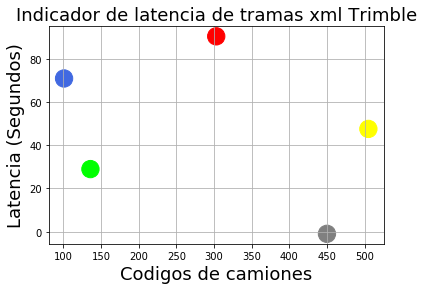

In [1040]:
plt.scatter(df.truck_code_num, df.diff_media, s=300, c=ref_colors)
plt.title('Indicador de latencia de tramas xml Trimble', fontsize=18)
plt.xlabel('Codigos de camiones', fontsize=18)
plt.ylabel('Latencia (Segundos)', fontsize=18)
plt.grid(True)

In [1041]:
# clear data
raw_data = {'truck_code': [], 
        'diff_media': [],
        'media_scale': [],
        'truck_code_num': []}
df = pd.DataFrame(raw_data, columns = ['truck_code', 'diff_media', 'media_scale', 'truck_code_num'])
ref_colors = [scale_colors[x] for x in df['media_scale']]
df.head()

Empty DataFrame
Columns: [truck_code, diff_media, media_scale, truck_code_num]
Index: []

In [1042]:
# method to connect and get dataframe
def getEmptyDf():
    print("Obteniendo dataframe empty")
    raw_data = {'truck_code': [], 
        'diff_media': [],
        'media_scale': [],
        'truck_code_num': []}
    df = pd.DataFrame(raw_data, columns = ['truck_code', 'diff_media', 'media_scale', 'truck_code_num'])
    # ref_colors = [scale_colors[x] for x in df['media_scale']]
    return df

def getDataFrameSimple(_sql, _conn):
    try:        
        df = pd.read_sql(sql, _conn)
    except Exception as ex:
        # print(ex)
        df = getEmptyDf()
    return df

def getDataFrameDirect(_sql):
    try:        
        c = pyodbc.connect(connStr, timeout=1)
        df = pd.read_sql(sql, c)
    except Exception as ex:
        print(ex)
        df = getEmptyDf()
    finally:
        if c:
            c.close()        
    return df


from threading import Lock
t_lock = Lock()

def retryGetDataFrame(_sql):
    try:
        with t_lock:
            print("Reintentado reconectar y obtener datos")
            global cnxn
            cnxn = pyodbc.connect(connStr, timeout=1)
            cursor = cnxn.cursor()
            cursor.execute("SELECT @@SPID")
            print("Reconexion a base de datos correcta con SPID: " + str(cursor.fetchone()[0]))
        df = pd.read_sql(sql, cnxn)
    except Exception as ex:
        print(ex)
        df = getEmptyDf()
    return df
        

def getDataFrame(_sql):
    try:        
        df = pd.read_sql(sql, cnxn)
    except Exception as ex:
        print(ex)
        df = retryGetDataFrame(_sql)
    return df


In [1043]:
getDataFrame(sql).head()

truck_code  diff_media  media_scale  truck_code_num
0        343   15.166667            1             343
1        392   14.686275            1             392
2        396   15.000000            1             396
3        410  141.642857            4             410
4        419   15.888889            1             419

In [1111]:
dfQ

truck_code  diff_media  media_scale  truck_code_num
0         343   15.166667            1             343
1         392   14.686275            1             392
2         396   15.000000            1             396
3         410  141.642857            4             410
4         419   15.888889            1             419
5         423   63.517241            3             423
6         443  122.811688            4             443
7         448   10.630769            1             448
8         452   15.272727            1             452
9         501   46.648649            2             501
10        514   67.648649            3             514
11        583  -60.000000           -1             583
12        660   12.800000            1             660
13        768   97.307692            4             768

In [11]:
gp = dfQ.groupby(['media_scale'])['truck_code'].count()
gpf = gp.to_frame()
total_camiones = gp.sum()
dfTemp = pd.DataFrame({'truck_code': [0, 0, 0, 0, 0]}, index=[-1, 1, 2, 3, 4])
dfTemp.index.name = "media_scale"
dfFinal = gpf.join(dfTemp, how='right', lsuffix='_left', rsuffix='_right')
serieFinal = dfFinal['truck_code_left'].fillna(0)
serieFinalPorcentajes = serieFinal / (total_camiones * 0.01)
list(serieFinal), [str(i) + '%' for i in serieFinalPorcentajes.round(2)]

([1, 7, 1, 2, 3], ['7.14%', '50.0%', '7.14%', '14.29%', '21.43%'])

In [1144]:
dfFinal

truck_code_left  truck_code_right
media_scale                                   
-1                         1                 0
 1                         7                 0
 2                         1                 0
 3                         2                 0
 4                         3                 0

In [1737]:
def checkConection(_cnxn):
    cur=None
    try:
        cur = _cnxn.cursor()
        cur.execute("SELECT 1;")
        return True
    except Exception as ex:
        print(ex)
    finally:
        if cur:
            cur.close()
    return False

def checkConection2(_cnxn):
    try:
        with _cnxn.cursor() as cur:
            cur.execute("SELECT 1;")
        return True
    except Exception as ex:
        print(ex)
    return False
    

In [1762]:
checkConection2(cnxn)

True